# Quantum Phase Estimation of Random 4x4 Hermitian Matrix

Authors: Takumi Kato (Blueqat inc.), Maho Nakata (Riken), Shinya Morino, Seiya Sugo (Quemix inc.), Yuichiro Minato (Blueqat inc.)

[Last time](114_pea2_en.ipynb), we calculated the eigenvalues of 2x2 Hermitian matrix. This time, we perform the quantum phase estimation of a random generated 4x4 Hermitian matrix.

Calculating eigenvalues of Hermitian matrices is useful for finding physical quantities in quantum mechanics. It has wide range of applications in fields such as quantum chemistry and quantum simulation.

## Implementation
First, we import required libraries. In this time, we use [qgate](https://github.com/shinmorino/qgate) backend.

In [1]:
import math
import cmath
import random
import numpy as np

from blueqat import *
from blueqat.pauli import X, Y, Z, I

BlueqatGlobalSetting.set_default_backend('qgate')
pi = math.pi

# Version check for Blueqat
try:
    Circuit().r(0.1)[0].run()
except AttributeError:
    raise ImportError('Blueqat version is old.')

In [2]:
# Qgate installation check
try:
    Circuit().x[0].run_with_qgate()
except ModuleNotFoundError:
    raise ImportError('Qgate is not installed.')

In [3]:
# If ImportError is occured, you didn't install Qgate.
# You can use Qgate without CUDA, but it's recommended on Linux environment.
# https://github.com/shinmorino/qgate#build--install

# To install pre-built package, run following command.

# For Python 3.8 user:
# !pip install https://github.com/shinmorino/qgate/raw/gh-pages/packages/0.2/qgate-0.2.2-cp38-cp38-manylinux1_x86_64.whl

# For Python 3.7 user:
# !pip install https://github.com/shinmorino/qgate/raw/gh-pages/packages/0.2/qgate-0.2.2-cp37-cp37m-manylinux1_x86_64.whl

# For Python 3.6 user:
# !pip install https://github.com/shinmorino/qgate/raw/gh-pages/packages/0.2/qgate-0.2.2-cp36-cp36m-manylinux1_x86_64.whl

# Don't install and use numba backend
# BlueqatGlobalSetting.set_default_backend('numba')

Then, we make a random Hermitian matrix $\hat H$.

To obtain the eigenvalue by quantum phase estimation, we also need
- A quantum circuit which gives the eigenvector of $\hat H$ corresponding with desired eigenvalue
- A quantum circuit which gives Controlled-$e^{i2\pi \hat H 2^n}$.

We will create them.

A Hermitian matrix can be decomposed into $\hat H = P D P^\dagger$
where $P$ is a unitary matrix, $D$ is a real diagonal matrix.

In this case, diagonal elements of $D$ are eigenvalues of $\hat H$ and each column of $P$ are eigenvalues of $\hat H$. Now, we're considering a 4x4 Hermitian. Thus, we need random generated SU(4) circuit. Such a SU(4) circuit can be generated from 4 SU(2) matrices and a matrix with 3 parameters. (Refer [arXiv:quant-ph/0507171](https://arxiv.org/abs/quant-ph/0507171))

![circuit](img/115_1.png)

Where $e^{iH} = e^{i(k_1 \sigma_{XX} + k_2 \sigma_{YY} + k_3 \sigma_{ZZ})}$,
$k_i$ are parameters and $\sigma_{**}$ are Kronecker product of Pauli matrices.

Now, we can define the function which returns

- A Hermitian matrix $\hat H$
- eigenvalues, which we desired to calculate
- A circuit, which gives the eigenvector of $\hat H$.

In [4]:
def is_hermitian(mat):
    """Check whether mat is Hermitian"""
    return np.allclose(mat, mat.T.conjugate())

def circuit_to_unitary(c):
    """Get a unitary matrix from circuit"""
    n_qubits = c.n_qubits
    def bits(n):
        return tuple(i for i in range(8) if (1 << i) & n)
    vecs = []
    for i in range(2**n_qubits):
        c0 = Circuit().x[bits(i)]
        c0 += c
        vecs.append(c0.run().reshape((-1, 1)))
    return np.hstack(vecs)

def rand_2pi():
    return random.random() * 2 * pi

def rand_eigval():
    return random.random() * 2 - 1

def random_su4_circuit():
    c = Circuit()
    c.u(rand_2pi(), rand_2pi(), rand_2pi())[0]
    c.u(rand_2pi(), rand_2pi(), rand_2pi())[1]
    c.cx[0, 1].rx(rand_2pi())[0].h[0].rz(rand_2pi())[1]
    c.cx[0, 1].s[0].h[0].rz(rand_2pi())[1]
    c.cx[0, 1].sdg[0].h[0].sdg[0].s[1].h[1].s[1]
    c.u(rand_2pi(), rand_2pi(), rand_2pi())[0]
    c.u(rand_2pi(), rand_2pi(), rand_2pi())[1]
    return c

def random_hermitian():
    """Make random Hermitian and returns triplet
    (Hermitian, eigenvalues, Circuit for making eigenvectors).
    """
    # Generate random eigenvalue
    eigvals = [rand_eigval(), rand_eigval(), rand_eigval(), rand_eigval()]
    eigvals.sort()
    su4 = random_su4_circuit()
    # Make Hermitian from them
    p = circuit_to_unitary(su4)
    hermitian = p @ np.diag(eigvals) @ p.T.conjugate()
    # Check it is Hermitian
    assert is_hermitian(hermitian)
    # returns Hermitian, eigenvalue, circuit
    return hermitian, eigvals, su4

OK. We will make a Hermitian.

In [5]:
H, eigvals, su4 = random_hermitian()
print('H:')
print(H)
print()
print('Eigenvalues:')
print(eigvals)
print()
print('Eigenvectors (P = [v1 v2 v3 v4]):')
P = circuit_to_unitary(su4)
print(P)
print()
print('P D P† = H? (D = diagonal matrix of eigenvalues):', np.allclose(P @ np.diag(eigvals) @ P.T.conjugate(), H))

H:
[[-0.3602787 +6.93889390e-18j -0.16847036+4.50532033e-01j
  -0.07103875-2.17509961e-01j -0.09194124-2.17742115e-01j]
 [-0.16847036-4.50532033e-01j  0.39806629+0.00000000e+00j
   0.12594163-1.67494694e-01j  0.0500555 +1.22112697e-02j]
 [-0.07103875+2.17509961e-01j  0.12594163+1.67494694e-01j
   0.07977263+2.77555756e-17j  0.58716814+4.58725159e-02j]
 [-0.09194124+2.17742115e-01j  0.0500555 -1.22112697e-02j
   0.58716814-4.58725159e-02j -0.24505159+0.00000000e+00j]]

Eigenvalues:
[-0.7056969713621091, -0.7054962616978162, 0.6190267913204479, 0.6646750744522858]

Eigenvectors (P = [v1 v2 v3 v4]):
[[ 0.5243647 +0.02788284j -0.00403505+0.68144135j  0.47805499-0.09155162j
  -0.14915106-0.02685705j]
 [ 0.05219516+0.32248169j -0.24825946+0.13123448j -0.31959717-0.4095473j
  -0.05539297+0.7358575j ]
 [ 0.53159258-0.12789668j  0.12553904-0.32121597j -0.15515137+0.49456818j
  -0.47902153+0.28979434j]
 [-0.561247  -0.05999184j  0.21686463+0.53925516j -0.13127266+0.45531115j
  -0.26623217+0.2194

We can make an eigenvector using `theta, phi, lam` and U gate.

In [6]:
vec = su4.run()
print(vec)

[ 0.5243647 +0.02788284j  0.05219516+0.32248169j  0.53159258-0.12789668j
 -0.561247  -0.05999184j]


Check `H vec = E vec`, it means, `E, vec` is a pair of eigenvalue and eigenvector of H.

In [7]:
np.allclose(np.dot(H, vec), eigvals[0] * vec)

True

Preparation is done. We will implement quantum phase estimation. We make the quantum circuit and calculate `E` by quantum phase estimation.

In [8]:
def iqft(c, q0, n_qubits):
    """Add inversed quantum Fourier transform operations to q0-th - (q0 + n_qubits)-th qubits of the circuit `c`"""
    for i in reversed(range(n_qubits)):
        angle = -0.5
        for j in range(i + 1, n_qubits):
            c.cr(angle * pi)[q0 + j, q0 + i]
            angle *= 0.5
        c.h[q0 + i]
    return c


def apply_cu(c, ctrl, su4, eigvals, n):
    """Append Controlled-U^(2^n) to the circuit `c`.
    Controll qubit is `ctrl`, target qubit is 0 and 1.
    
    This function requires eigenvalue `eigval` as an argument.
    We make Controlled-U^(2^n) by using eigenvalue. You may feel we're cheating.
    You can make approximate Controlled-U^(2^n) circuit without eigenvalue,
    for example by using Suzuki-Trotter decomposition. In this case, you have to consider about precision.
    Generally, making efficient and high-precision Controlled-U^(2^n) circuit without cheating is difficult.
    """
    bias = 0.25 * sum(eigvals)
    p, q, r, s = [v - bias for v in eigvals]
    p1 = pi * (r + s)
    p2 = pi * (q + s)
    p3 = pi * (q + r)
    c += su4.dagger()
    c.crz(p1 * (2**n))[ctrl, 1]
    c.crz(p2 * (2**n))[ctrl, 0]
    c.ccx[ctrl, 1, 0].crz(p3 * (2**n))[ctrl, 0].ccx[ctrl, 1, 0]
    c.rz(pi * bias * (2**n))[ctrl]
    c += su4
    return c

def qpe_circuit(initial_circuit, eigvals, su4, precision):
    """Returns quantum phase estimation circuit"""
    c = initial_circuit + su4
    c.h[2:2 + precision]
    for i in range(precision):
        apply_cu(c, i + 2, su4, eigvals, i)
    iqft(c, 2, precision)
    return c

Let's see the quantum circuit of quantum phase estimation.

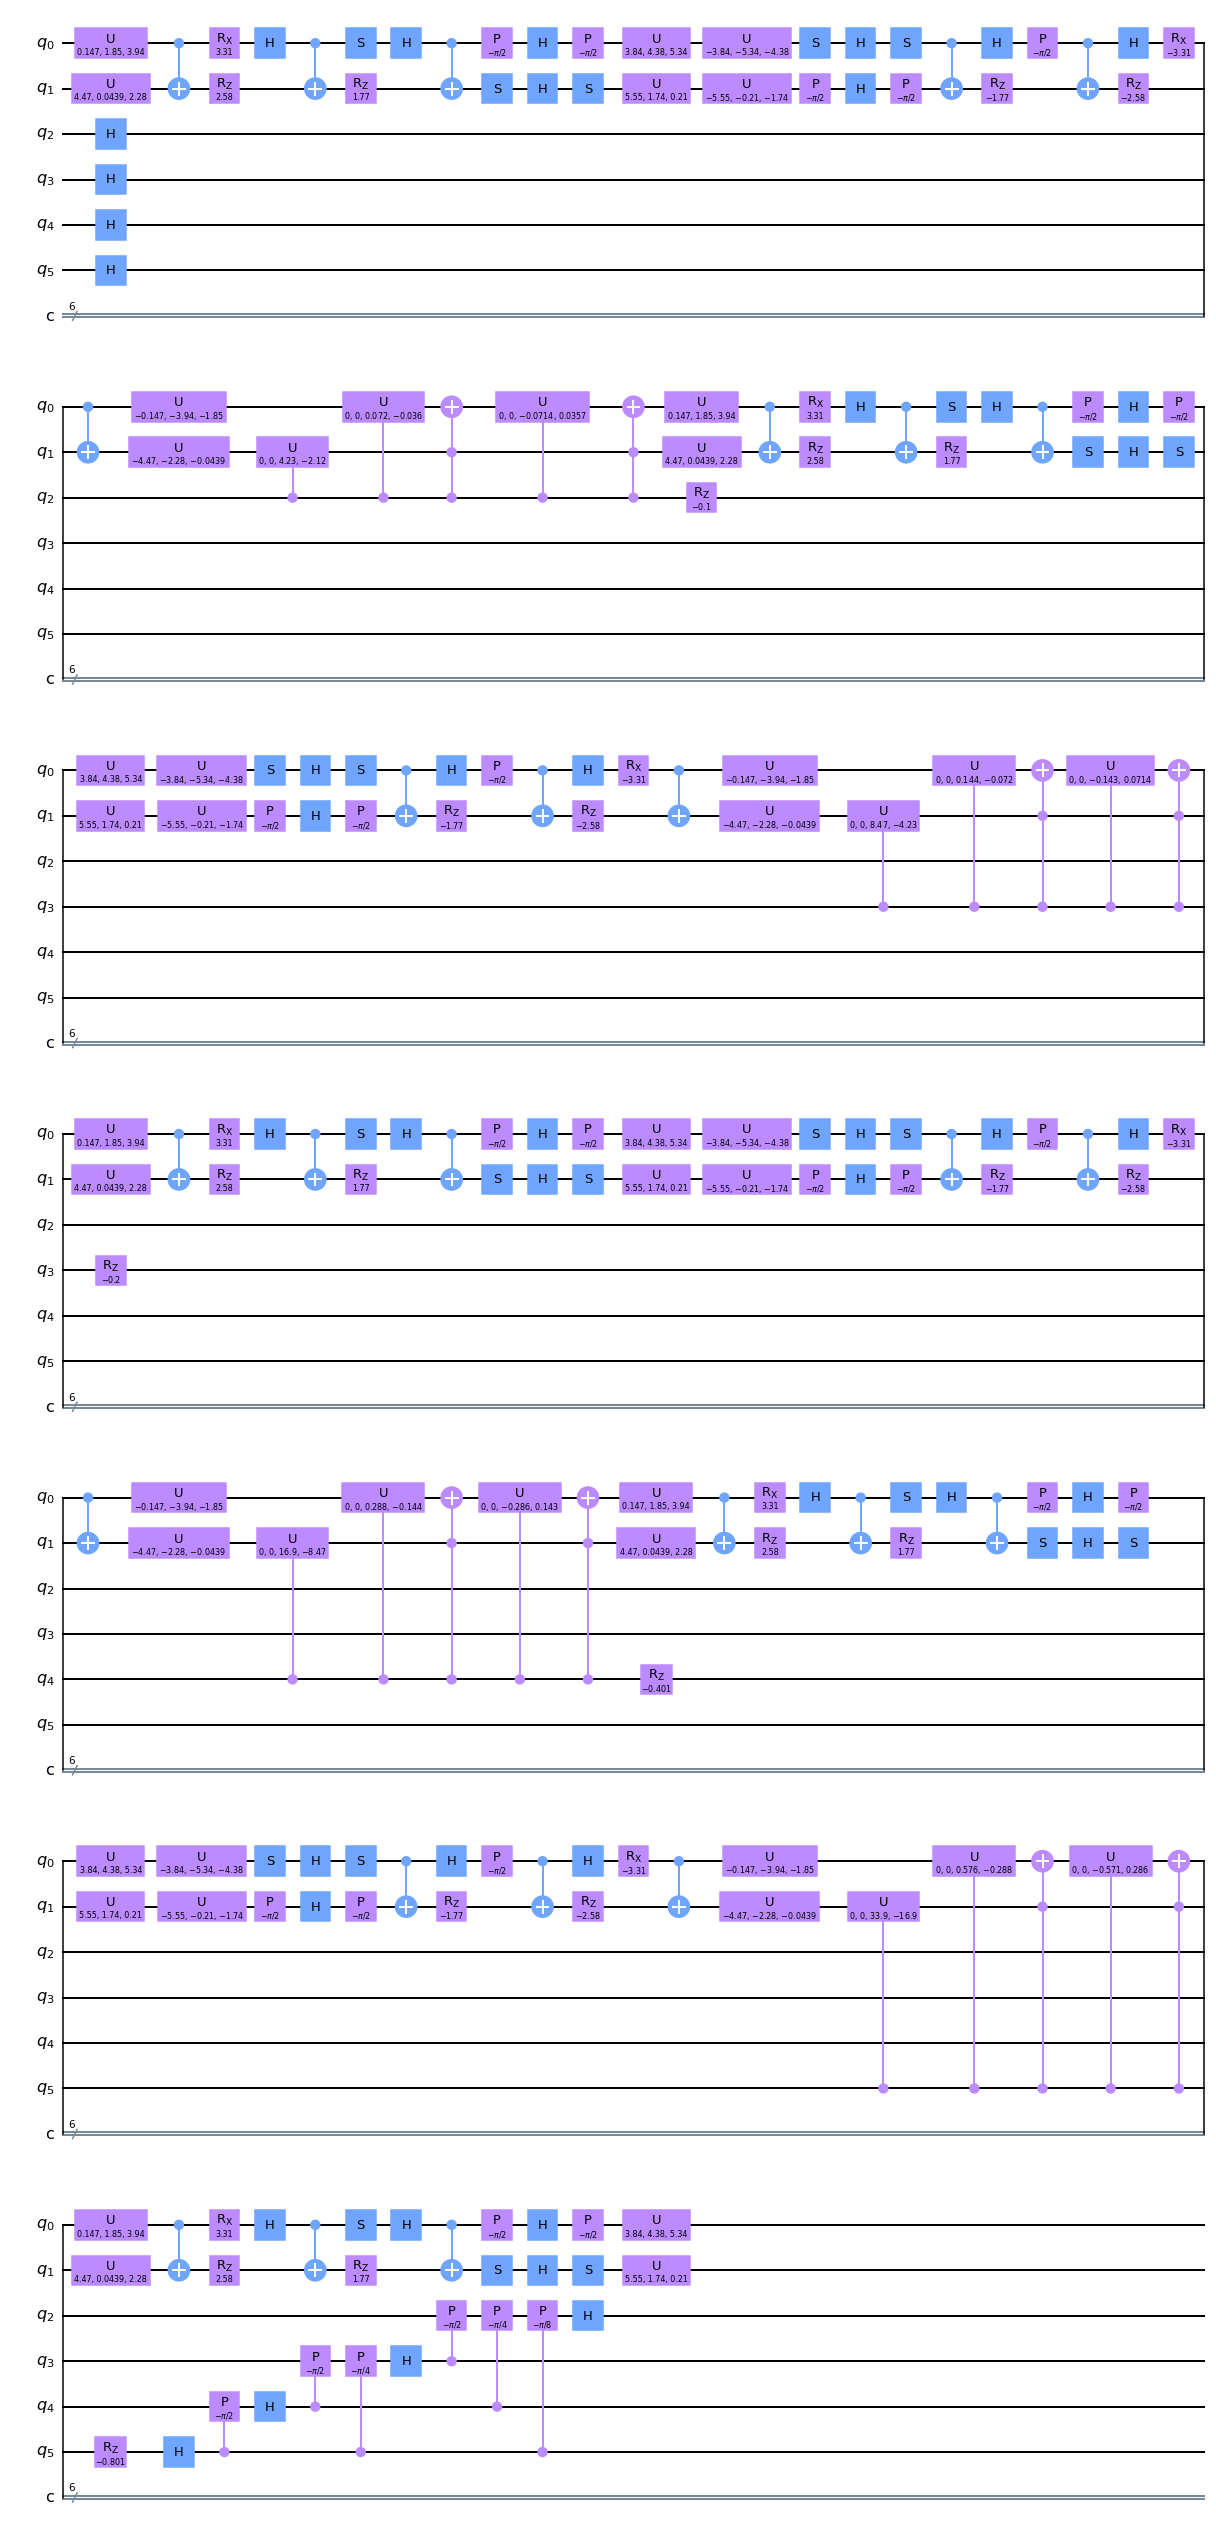

In [9]:
qpe_circuit(Circuit(), eigvals, su4, 4).run_with_ibmq(returns='draw', output='mpl')

Then, we make a function for calculating the eigenvalue from observed result.

In [10]:
def run_qpe(c, shots=1000, max_candidates=5):
    """Run the circuit for quantum phase estimation and returns candidates of eigenvalue.
    shots: The number of running quantum circuit, max_candidates: Maximum number of candidates
    """
    cnt = c.m[2:].run(shots=shots)

    # Convert measured result to floating point value
    def to_value(k):
        k = k[2:] # Drop unnecessary element
        val = 0 # Value
        a = 1.0 
        for ch in k:
            if ch == '1':
                val += a
            a *= 0.5
        if val > 1:
            # When the phase > π, subtract 2π (phase is negative).
            val = val - 2
        return val

    return [(to_value(k), v) for k, v in cnt.most_common(max_candidates)]

Now, we can perform the quantum phase estimation. Let's see the result.

In [11]:
print('Eigenvalue (expected):', eigvals[0]) # It's expected value. We desire a value closed to it.
# We'll run small to high precision for comparison.
for precision in range(3, 16):
    print(precision, 'bit precision:')
    c = qpe_circuit(Circuit(), eigvals, su4, precision)
    result = run_qpe(c, 1000, 3)
    for value, count in result:
        # Display a number of observation, obtained eigenvalue and a deviation from true eigenvalue.
        print(f'{count:<5}{value:<18}(deviation: {value - eigvals[0]: .3e})')
    print('')

Eigenvalue (expected): -0.7945019526444816
3 bit precision:
906  -0.75             (deviation:  4.450e-02)
36   1.0               (deviation:  1.795e+00)
22   -0.5              (deviation:  2.945e-01)

4 bit precision:
650  -0.75             (deviation:  4.450e-02)
185  -0.875            (deviation: -8.050e-02)
48   -0.625            (deviation:  1.695e-01)

5 bit precision:
731  -0.8125           (deviation: -1.800e-02)
121  -0.75             (deviation:  4.450e-02)
47   -0.875            (deviation: -8.050e-02)

6 bit precision:
548  -0.78125          (deviation:  1.325e-02)
292  -0.8125           (deviation: -1.800e-02)
43   -0.84375          (deviation: -4.925e-02)

7 bit precision:
915  -0.796875         (deviation: -2.373e-03)
37   -0.78125          (deviation:  1.325e-02)
21   -0.8125           (deviation: -1.800e-02)

8 bit precision:
695  -0.796875         (deviation: -2.373e-03)
165  -0.7890625        (deviation:  5.439e-03)
45   -0.8046875        (deviation: -1.019e-02)

9 b

Obtained value are near by true eigenvalue.

Then, we calculate 2nd eigenvalue.

In [12]:
print('Eigenvalue (expected):', eigvals[1]) # It's expected value. We desire a value closed to it.
# We'll run small to high precision for comparison.
for precision in range(3, 16):
    print(precision, 'bit precision:')
    c = qpe_circuit(Circuit().x[0], eigvals, su4, precision)
    result = run_qpe(c, 1000, 3)
    for value, count in result:
        # Display a number of observation, obtained eigenvalue and a deviation from true eigenvalue.
        print(f'{count:<5}{value:<18}(deviation: {value - eigvals[1]: .3e})')
    print('')

Eigenvalue (expected): 0.28570068909309354
3 bit precision:
926  0.25              (deviation: -3.570e-02)
32   0.5               (deviation:  2.143e-01)
21   0                 (deviation: -2.857e-01)

4 bit precision:
749  0.25              (deviation: -3.570e-02)
131  0.375             (deviation:  8.930e-02)
38   0.125             (deviation: -1.607e-01)

5 bit precision:
534  0.3125            (deviation:  2.680e-02)
296  0.25              (deviation: -3.570e-02)
39   0.375             (deviation:  8.930e-02)

6 bit precision:
932  0.28125           (deviation: -4.451e-03)
30   0.3125            (deviation:  2.680e-02)
19   0.25              (deviation: -3.570e-02)

7 bit precision:
761  0.28125           (deviation: -4.451e-03)
128  0.296875          (deviation:  1.117e-02)
34   0.265625          (deviation: -2.008e-02)

8 bit precision:
533  0.2890625         (deviation:  3.362e-03)
291  0.28125           (deviation: -4.451e-03)
49   0.296875          (deviation:  1.117e-02)

9 b

Ok. Let's calculate 3rd one.

In [13]:
print('Eigenvalue (expected):', eigvals[2]) # It's expected value. We desire a value closed to it.
# We'll run small to high precision for comparison.
for precision in range(3, 16):
    print(precision, 'bit precision:')
    c = qpe_circuit(Circuit().x[1], eigvals, su4, precision)
    result = run_qpe(c, 1000, 3)
    for value, count in result:
        # Display a number of observation, obtained eigenvalue and a deviation from true eigenvalue.
        print(f'{count:<5}{value:<18}(deviation: {value - eigvals[2]: .3e})')
    print('')

Eigenvalue (expected): 0.3578678227869243
3 bit precision:
511  0.25              (deviation: -1.079e-01)
298  0.5               (deviation:  1.421e-01)
58   0.75              (deviation:  3.921e-01)

4 bit precision:
936  0.375             (deviation:  1.713e-02)
23   0.25              (deviation: -1.079e-01)
15   0.5               (deviation:  1.421e-01)

5 bit precision:
763  0.375             (deviation:  1.713e-02)
114  0.3125            (deviation: -4.537e-02)
45   0.4375            (deviation:  7.963e-02)

6 bit precision:
504  0.34375           (deviation: -1.412e-02)
320  0.375             (deviation:  1.713e-02)
44   0.40625           (deviation:  4.838e-02)

7 bit precision:
973  0.359375          (deviation:  1.507e-03)
10   0.375             (deviation:  1.713e-02)
9    0.34375           (deviation: -1.412e-02)

8 bit precision:
874  0.359375          (deviation:  1.507e-03)
55   0.3515625         (deviation: -6.305e-03)
34   0.3671875         (deviation:  9.320e-03)

9 bi

The last eigenvalue is:

In [14]:
print('Eigenvalue (expected):', eigvals[3]) # It's expected value. We desire a value closed to it.
# We'll run small to high precision for comparison.
for precision in range(3, 16):
    print(precision, 'bit precision:')
    c = qpe_circuit(Circuit().x[0, 1], eigvals, su4, precision)
    result = run_qpe(c, 1000, 3)
    for value, count in result:
        # Display a number of observation, obtained eigenvalue and a deviation from true eigenvalue.
        print(f'{count:<5}{value:<18}(deviation: {value - eigvals[3]: .3e})')
    print('')

Eigenvalue (expected): 0.8041869501627237
3 bit precision:
837  0.75              (deviation: -5.419e-02)
88   1.0               (deviation:  1.958e-01)
28   0.5               (deviation: -3.042e-01)

4 bit precision:
500  0.75              (deviation: -5.419e-02)
337  0.875             (deviation:  7.081e-02)
54   0.625             (deviation: -1.792e-01)

5 bit precision:
934  0.8125            (deviation:  8.313e-03)
32   0.75              (deviation: -5.419e-02)
12   0.875             (deviation:  7.081e-02)

6 bit precision:
809  0.8125            (deviation:  8.313e-03)
77   0.78125           (deviation: -2.294e-02)
42   0.84375           (deviation:  3.956e-02)

7 bit precision:
475  0.796875          (deviation: -7.312e-03)
345  0.8125            (deviation:  8.313e-03)
41   0.78125           (deviation: -2.294e-02)

8 bit precision:
983  0.8046875         (deviation:  5.005e-04)
5    0.796875          (deviation: -7.312e-03)
3    0.8125            (deviation:  8.313e-03)

9 bi